In [4]:
"""
Here are some of the Basic imports that I will be using within my notebook
"""

import torch
import numpy as np
import random
import torch.nn as nn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
from typing import List
import time
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F


In [5]:
# import pandas as pd
df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv.zip")

# Printing the head of the data frame
df.head(20)

# Identify Columns/Features
# print(df.columns)
columns = [' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' ECE Flag Count', ' Down/Up Ratio', ' Average Packet Size',
       ' Avg Fwd Segment Size', ' Avg Bwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes',
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' act_data_pkt_fwd',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min',
       ' Label']


# identify the shape
# df.shape
# Shape is 79 columns and 225745 rows.

# figure out how many actual ddos attacks occured
rslt_df = df[df[' Label'] == 'BENIGN']
print("DDos attacks: ",225745 - rslt_df.shape[0])
print("DDos Data Coverage (%) : ", (rslt_df.shape[0] / 225745)* 100)


DDos attacks:  128027
DDos Data Coverage (%) :  43.28689450486168


# Understanding the data with plots

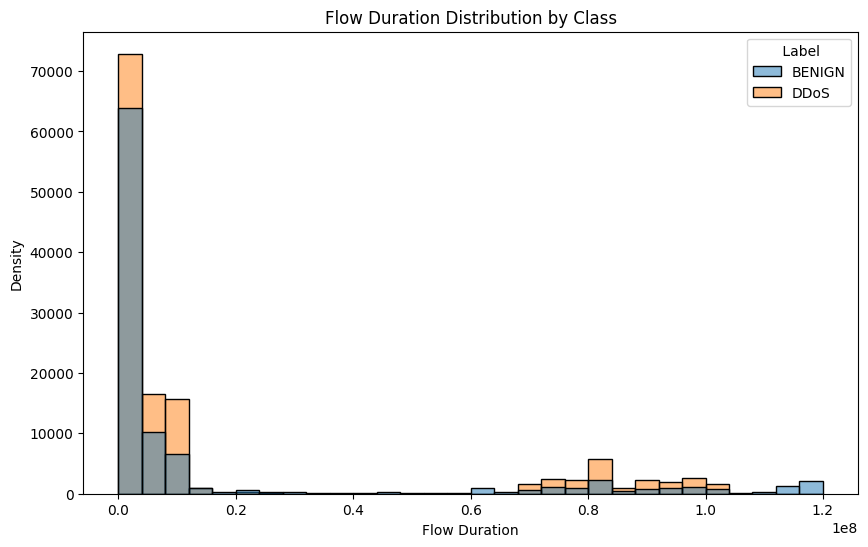

In [6]:
# from matplotlib import pyplot as plt
# import seaborn as sns

# To observe the means to help support the plot
# means = df.groupby(' Label')[[' Flow Duration']].mean()
# print(means)

# Plotting distribution for 'Flow Duration'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=' Flow Duration', hue=' Label', bins=30)
plt.title('Flow Duration Distribution by Class')
plt.xlabel('Flow Duration')
plt.ylabel('Density')
plt.show()

one of the first things I wanted to look at was the flow duration.
flow duration is the time between the first packet being received by the computer and the last packet being received by a computer. As you can see a majority of the packets received classified by both BENIGN and DDos are within the area of 0.0 to 0.2.

Understanding that DDos is usually utilizing a botnet to overwhelm a service with lots of requests helps identify what the flow rate might be for a DDos attacks.

It looks like alot of the flow rate for DDos attacks fall within the 0.0 to 0.2 range with a small cluster between 0.7 and 1.0.

But since it also seems like a majority of the classified BENIGN also falls within these ranges aswell as some other ranges It doesnt seem that flow rate might be the best indicator for DDos alone but will require some more thought.


    Label    Mean Flow Duration           
    BENIGN   1.530626e+07
    DDoS     1.695559e+07

---



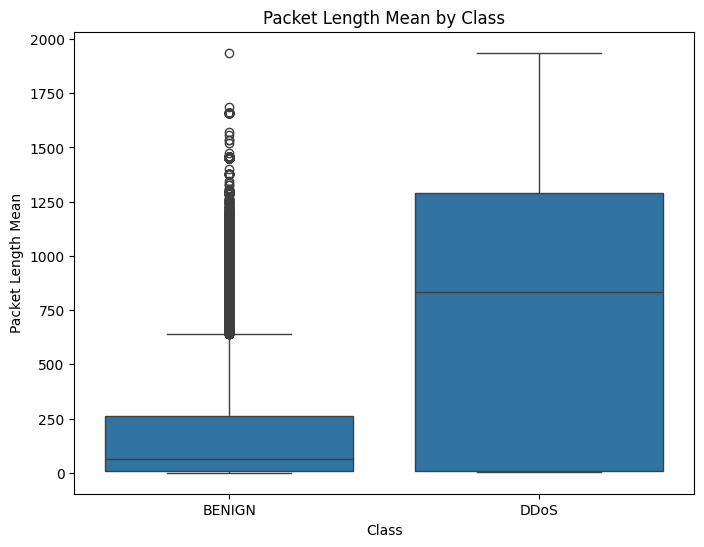

In [7]:

# https://www.geeksforgeeks.org/boxplot-using-seaborn-in-python/
# Box plot of Packet Length Mean by class
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x=' Label', y=' Packet Length Mean')
plt.title('Packet Length Mean by Class')
plt.xlabel('Class')
plt.ylabel('Packet Length Mean')
plt.show()

Another Thing that possibly came to mind when identifying DDos attacks would be packet lengths. Since their are different forms of DDOS attacks I would think that the packet lengths would possibly vary largerly depending on the DDos method. I think a large range of pacekt lengths would also be an attempt to build a defense against detection as having a varied length would require a more sophisticated detection system than checking if a packet is certain length.

here are some take aways from my boxplot.

    BENIGN
    *   IQR of 0-250
    *   Mean close to 0
    *   Classified outliers after around 600
    *   minimum of around 0
    *   Maximum of around 600

    DDos
    * IQR of 0-1250
    * Mean close to 800
    * No classified Outliers
    * minimum of around 0
    * maximum around 1900

---

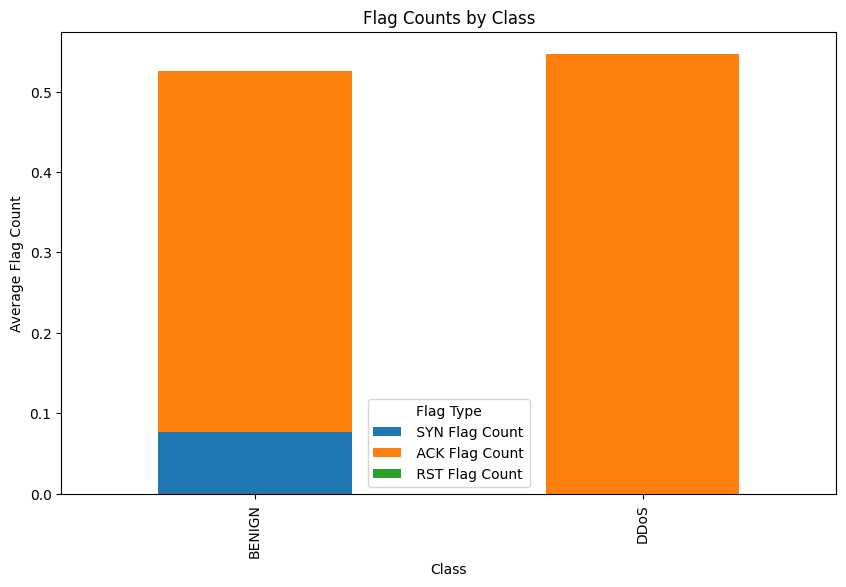

In [8]:

# https://www.geeksforgeeks.org/how-to-create-a-stacked-bar-plot-in-seaborn/#
# Flag Analysis for Attack Signatures
flag_counts = df.groupby(' Label')[[' SYN Flag Count', ' ACK Flag Count', ' RST Flag Count']].mean()

# print out the means to help support the plot
# print(flag_counts)

# Plotting SYN, ACK, and RST flag counts
flag_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Flag Counts by Class')
plt.xlabel('Class')
plt.ylabel('Average Flag Count')
plt.legend(title='Flag Type')
plt.show()

Another things that I wanted to observe was the possible flags that each label was coming up with involved in the three way and shake for TCP protocol speciffically the SYN and ACK flag. Since DDOs attacks dont establish a full connection wich is shown by the SYN flag. the traffic identified as DDos doesnt have identified SYN flags wich is as expected.


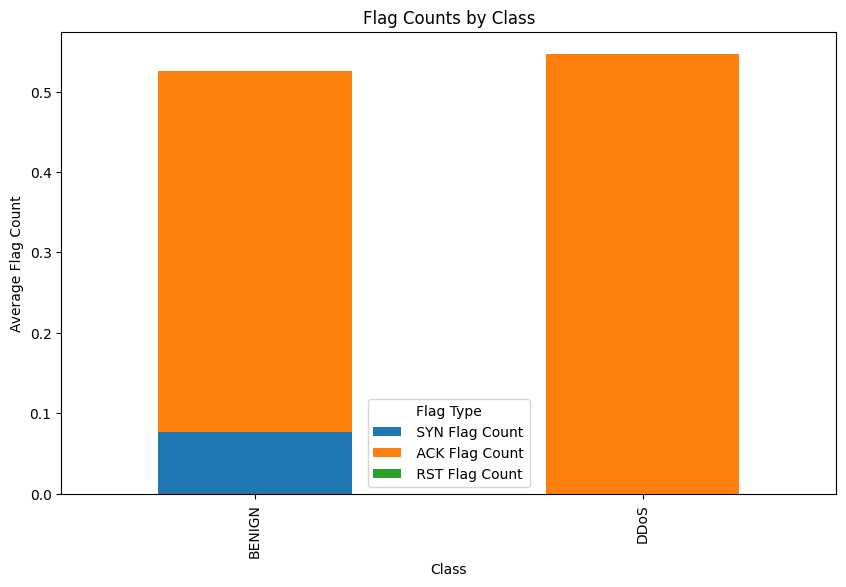


                        MEANS
    Label   SYN Flag Count  ACK Flag Count  RST Flag Count                                         
    BENIGN    0.076751        0.448965        0.000276
    DDoS      0.000000        0.546822        0.000000

---

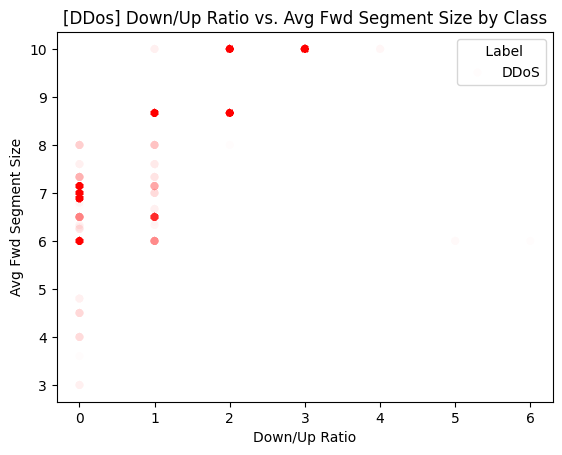

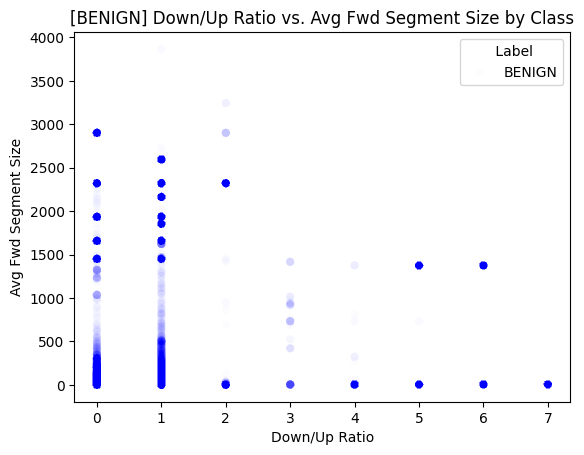

In [9]:

df_ddos = df[df[' Label'] == 'DDoS']
df_benign = df[df[' Label'] == 'BENIGN']


# To observe the means to help support the plot
# means = df.groupby(' Label')[[' Down/Up Ratio', ' Avg Fwd Segment Size']].mean()
# print(means)

# Need to create a new color pallette thats very distinguishable
# Changing alpha to a lower number might help see if any DDos is on the graph and where
# aswell as where the majority of points lie. darker/denser

custom_palette = {'DDoS': 'red','BENIGN': 'blue',}
sns.scatterplot(data=df_ddos, x=' Down/Up Ratio', y=' Avg Fwd Segment Size', hue=' Label', alpha=0.01, palette=custom_palette,)
plt.title('[DDos] Down/Up Ratio vs. Avg Fwd Segment Size by Class')
plt.xlabel('Down/Up Ratio')
plt.ylabel('Avg Fwd Segment Size')
plt.show()

sns.scatterplot(data=df_benign, x=' Down/Up Ratio', y=' Avg Fwd Segment Size', hue=' Label', alpha=0.01, palette=custom_palette,)
plt.title('[BENIGN] Down/Up Ratio vs. Avg Fwd Segment Size by Class')
plt.xlabel('Down/Up Ratio')
plt.ylabel('Avg Fwd Segment Size')
plt.show()

The Last thing I wanted to look at was the Down/Up ratio and the Average forward Segment size.

Since the Down Up ratio is a ratio of the of data flowing Down from server to client and Up from client to server. A ratio with a high flow up stream would result in a smaller ratio where as a ratio with a high flow down strea would result in a larger ratio. When thinking about DDos the Up ratio should be higher than normal resulting in a smaller down up ratio. this is shown in the first graph in regards DDos. As you can also see for the plot in regards to Benign the Down Up ratio reaches a much higher value since data flowing from server to client appears to be more common with regular network traffic.

I also chose to look at the average forward Segment Size  which is the average size of the data being sent client to server to see how it compares to normal traffic. The Average forward Segment Size is much smaller in regards to DDos when compared to normal network traffic. This is expected since with DDos my thought of DDos is flooding a service with small packets.


                           MEANS
    Label       Down/Up Ratio  Avg Fwd Segment Size                    
    BENIGN       1.505884            371.080512
    DDoS         0.624142              7.401262

---

In [10]:

# need to seperate features and prediction values
X = df.drop(columns=[' Label']).values
y = (df[' Label'] == 'DDoS').astype(int).values  # Convert labels to 0 and 1

def prepare_data(X,Y):

  # get rid of nans
  X = np.nan_to_num(X)

  # reduce number sizes to make easier computationaly
  X = np.clip(X, -1e6, 1e6)

  # Normalize features
  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # Make into tensors
  X = torch.tensor(X, dtype=torch.float32)
  Y = torch.tensor(Y,dtype=torch.float32).view(-1,1) # need y predict to only have one column

  # split data into train and test
  X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

  train_dataset = TensorDataset(X_train[:,:],y_train[:,:])
  train_DataLoader = DataLoader(train_dataset,batch_size=64)

  test_dataset = TensorDataset(X_test[:,:],y_test[:,:])
  test_DataLoader = DataLoader(test_dataset,batch_size=64)

  # https://stackoverflow.com/questions/28663856/how-do-i-count-the-occurrence-of-a-certain-item-in-an-ndarray
  unique_train, counts_train = np.unique(y_train,return_counts=True)
  train_counts = dict(zip(unique_train, counts_train)) # one is BENIGN
  print(train_counts)
  unique_test, counts_test = np.unique(y_test,return_counts=True)
  test_counts = dict(zip(unique_test, counts_test)) # one is BENIGN

  print("-----------")
  print("X Shape  ",X_train[:,:].shape)
  print("Y Shape  ",y_train[:,:].shape)
  print("----------")
  print("DDos train ",train_counts.get(0))
  print("DDos test",test_counts.get(0))

  return train_DataLoader, test_DataLoader

train_DataLoader, test_DataLoader  = prepare_data(X,y)


{0.0: 78313, 1.0: 102283}
-----------
X Shape   torch.Size([180596, 78])
Y Shape   torch.Size([180596, 1])
----------
DDos train  78313
DDos test 19405


# First Model : Multi Layer Perceptron



In [27]:

input_dimension = 78  # Number of observed points 78
output_dimension = 1  # Number of predicted points 1

class MLPModel(nn.Module):
    def __init__(self,
                 input_dimension: int,
                 output_dimension: int,
                ):

        super(MLPModel, self).__init__()

        self.features = nn.Linear(input_dimension,128)
        self.relu = nn.ReLU()
        # output linear 128 * 1 + 1
        self.out = nn.Linear(128,output_dimension)

    def forward(self, features):

        out = self.features(features)
        out = self.relu(out)
        out = self.out(out)
        return out

# First Model : Training

In [28]:

# def training_loop(epochs: int, model: nn.Module, train, ground):
def training_loop(epochs: int, model: nn.Module, dataLoader):
    '''
    This functions takes the number of epochs and a model and then trains the model.
    Params:
        epochs: number of epochs the model will be trained
        model: the model that needs to be optimized for time series prediction
    '''

    # Set up the loss function and optimizer
    learning_rate = 0.005
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    training_losses = []

    # Training loop
    start = time.time()
    for epoch in range(epochs):
      for X_batch,Y_batch in dataLoader:

        model.train()  # Set the model to training mode

        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record training loss every 10 epochs
        if epoch % 10 == 0:
            training_losses.append(loss.item())
            # print(f'[MLP] Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

    end = time.time()
    length = end - start
    print("Time Completed:  ",length)
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    print("Last Loss",training_losses[-1])



Time Completed:   93.39740252494812


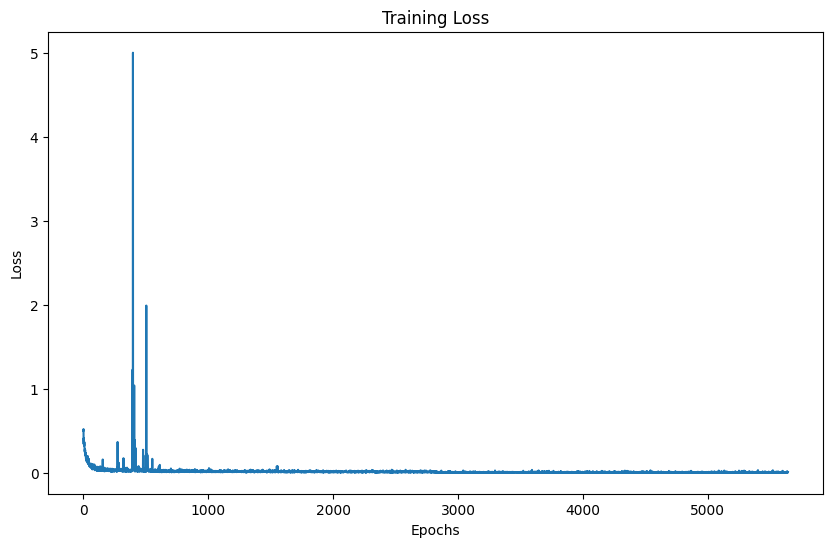

Last Loss 0.009264640510082245


In [29]:
model = MLPModel(input_dimension, output_dimension)
epochs = 20
training_loop(epochs, model,train_DataLoader)


# First Model : Evaluation


In [14]:

def evaluation_loop(model: nn.Module,test_loader):
    '''
    This functions takes the number of examples and a model and then evaluates the model.
    Params:
        n_examples: number of examples the model will be going through
        model: the model that is going to be evaluated
    Returns:
        a pair of lists of all the predictions and labels
    '''

    all_predictions, all_labels = [], []

    model.eval()
    with torch.no_grad():
        for X_batch,Y_batch in test_loader:

            prediction = model(X_batch)  # Add batch dimension if required
            prediction = prediction.squeeze(1).flatten()
            prediction = torch.clamp(prediction, min=0.0,max=1) # Clamp predictions to be within range 0 to one. set negatives to 0.

            all_predictions.append(prediction)
            all_labels.append(Y_batch.flatten())


    return torch.cat(all_predictions).round().numpy(), torch.cat(all_labels).round().numpy()


(all_prediction, all_label) = evaluation_loop(model,test_DataLoader)

45149


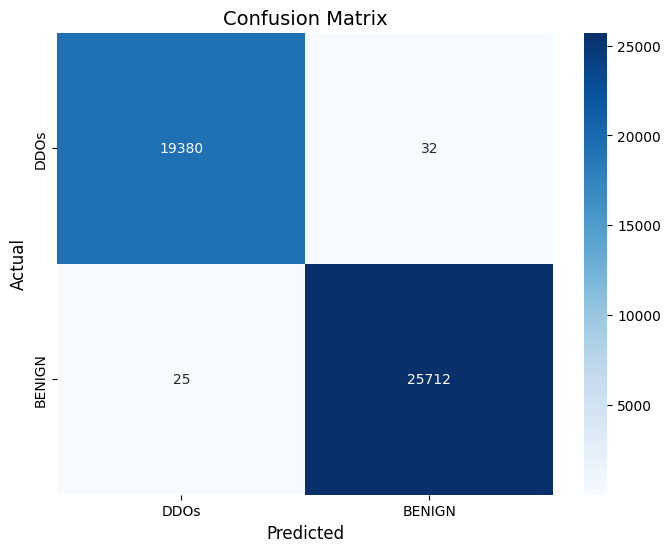

TP:  25712
FP:  25
TN:  19380
FN:  32
Accuracy:  0.9987375135661919
Precision:  0.9990286358161402
Recall:  0.9987569919204475
F-1 score: 0.9988927954002448


In [15]:
def graph_results(all_predictions: List[float], all_labels: List[float]):
  """
  graphs the  results of the model given the predictions and lables from evaluation
  Params:
    all_predictions: list of all the predictions
    all_labels: list of all the labels
  """

  cm = confusion_matrix(all_predictions, all_labels)
  class_labels = ['DDOs','BENIGN']
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted', fontsize=12)
  plt.ylabel('Actual', fontsize=12)
  plt.title('Confusion Matrix', fontsize=14)
  plt.show()


  # Set varaibles
  # TP if predicted and ground are true
  # FP if predicited is true ground is false
  # TN if predicted and ground are false
  # FN if predicted is false but ground is true
  TP = FP = TN = FN = 0

  all_accuracies = []
  all_precision = []
  all_recall = []
  all_f1 = []

  for pred, true in zip(all_predictions, all_labels):
      # pred_class = torch.round(pred)  # Adjust rounding/threshold based on problem requirements
      # for pred_value, trueValue in zip(pred_class, true):
        # break
        if pred == 1 and true == 1:
            TP += 1
        elif pred == 1 and true == 0:
            FP += 1
        elif pred == 0 and true == 0:
            TN += 1
        elif pred == 0 and true == 1:
            FN += 1

        # append accuracies,precision,recall,F1
        all_accuracies.append((TP + TN) / (TP + TN + FP + FN))
        all_precision.append(TP / (TP + FP) if TP+FP != 0 else TP)
        all_recall.append(TP / (TP + FN) if TP + FN != 0 else TP)
        all_f1.append(TP / (TP + .5 * (FP + FN)) if TP + .5 *(FP + FN) != 0 else TP)


  print("TP: ", TP)
  print("FP: ", FP)
  print("TN: ", TN)
  print("FN: ", FN)

  # https://www.educative.io/answers/precision-vs-recall-vs-accuracy-in-neural-networks
  # Formulas for Accuracy, Precision, and Recall
  print("Accuracy: ", (TP + TN) / (TP + TN + FP + FN))
  print("Precision: ", TP / (TP + FP))
  print("Recall: ", TP / (TP + FN))
  print("F-1 score:",(TP / (TP + .5 * (FP + FN))))
  return all_accuracies, all_precision, all_recall, all_f1

# mlp_accuracies = graph_results(all_prediction, all_label)
print(len(all_prediction))
mlp_accuracies, mlp_precision, mlp_recall, mlp_f1 = graph_results(all_prediction, all_label)

# Second Model : Multi-layer Perceptron with Additive Attention

In [16]:
"Hyper Parameters for NETWORK MODEL"

in_features = 78
out_features = 1
d_model = 128
d_attention = 128


Time Completed:   162.2643804550171


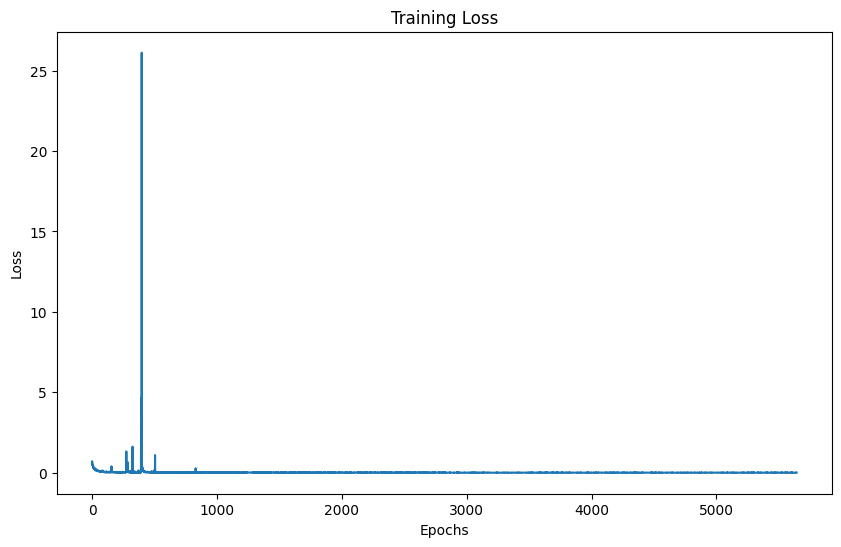

Last Loss 0.007381858304142952


In [17]:

class AdditiveAttention(nn.Module):
    def __init__(self,attention_dim):
        super(AdditiveAttention, self).__init__()

        # 2 * (128 * 128) = 32,768 parameters
        self.query_linear = nn.Linear(attention_dim,attention_dim,bias=False)
        self.key_linear = nn.Linear(attention_dim,attention_dim, bias=False)
        # combined tanh(query + keys)
        self.value_linear = nn.Linear(attention_dim,1, bias=False) # 128 * 1 = 128
        # weights = Softmax (value)
        # batch matrix matrix product of weights  and input values

        # Total Trainable Parameters 32,768 + 128 = 32896
        self.first = 0

    def forward(self, query, keys, values):

        # Transform query and keys
        query = self.query_linear(query).unsqueeze(2)
        keys = self.key_linear(keys).unsqueeze(1)

        # Compute combined representation and apply tanh
        combined = torch.tanh(query + keys)

        # Compute scores
        scores = self.value_linear(combined).squeeze(-1)

        # Normalize scores using softmax
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.bmm(attention_weights, values)

        return context

class NetworkModel(nn.Module):
    def __init__(self, input_dimension, output_dimension, hidden_dim, attention_dim):
        super(NetworkModel, self).__init__()

        # Feature transformation 78 * 128 + 128 = 10112
        self.features = nn.Linear(input_dimension,hidden_dim)
        self.relu = nn.ReLU()
        self.attention = AdditiveAttention(attention_dim) # 32896
        # output linear 128 * 1 + 1
        self.out = nn.Linear(hidden_dim,out_features)
        # Total Parameters 10112 + 32896 + 129 = 43,137


    def forward(self, features):

        # Input transformation
        transformed = self.features(features)
        transformed = self.relu(transformed)

        # add attention expects (batch size, seqlen,hidden_dim) so need to add dim
        query = transformed.unsqueeze(1)
        key = transformed.unsqueeze(1)
        value = transformed.unsqueeze(1)

        context = self.attention(query,key,value)
        context = context.squeeze(1)
        out = self.out(context)

        return out



network_model = NetworkModel(in_features, out_features, d_model, d_attention)

training_loop(epochs,network_model,train_DataLoader)

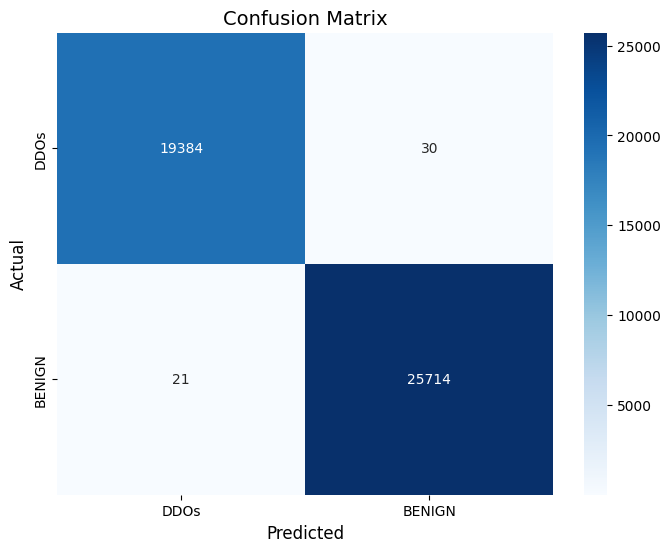

TP:  25714
FP:  21
TN:  19384
FN:  30
Accuracy:  0.9988704068750138
Precision:  0.9991839906741792
Recall:  0.9988346799254195
F-1 score: 0.9990093047650498


In [18]:
(all_prediction, all_label) = evaluation_loop(network_model,test_DataLoader)
networkModel_accuracies, networkModel_precision, networkModel_recall, networkModel_f1 = graph_results(all_prediction, all_label)

# NETWORK MODEL (Feature Ablation)

The The Network Traffic Data has while it has alot of features. I dont beleive all of these features to be useful. I will perform feature ablation with the data for the Networ Model. to decrease  training time, and possibly improve validation metrics.

In [19]:

# Groupts to drop from the data-frame

bwd_group = [' Total Length of Bwd Packets','Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std','Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min',' Bwd PSH Flags',' Bwd URG Flags',' Bwd Header Length',' Bwd Packets/s',' Avg Bwd Segment Size',' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate',' Subflow Bwd Packets', ' Subflow Bwd Bytes',' Label']

fwd_group = [' Total Fwd Packets','Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std','Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min',' Avg Fwd Segment Size',' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate',' Label']

flow_group = [' Flow Duration','Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',' Label']

flag_group = ['FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' ECE Flag Count',' Fwd Header Length',' Label']


bwd_drop_X = df.drop(columns=bwd_group).values
fwd_drop_X = df.drop(columns=fwd_group).values
flow_drop_X = df.drop(columns=flow_group).values
flag_counts_drop_X = df.drop(columns=flag_group).values

# prepare data loaders.

bwd_train_dataLoader, bwd_test_dataLoader = prepare_data(bwd_drop_X,y)
fwd_train_dataLoader, fwd_test_dataLoader = prepare_data(fwd_drop_X,y)
flow_train_dataLoader, flow_test_dataLoader = prepare_data(flow_drop_X,y)
flag_train_dataLoader, flag_test_dataLoader = prepare_data(flag_counts_drop_X,y)







{0.0: 78313, 1.0: 102283}
-----------
X Shape   torch.Size([180596, 58])
Y Shape   torch.Size([180596, 1])
----------
DDos train  78313
DDos test 19405
{0.0: 78313, 1.0: 102283}
-----------
X Shape   torch.Size([180596, 62])
Y Shape   torch.Size([180596, 1])
----------
DDos train  78313
DDos test 19405
{0.0: 78313, 1.0: 102283}
-----------
X Shape   torch.Size([180596, 71])
Y Shape   torch.Size([180596, 1])
----------
DDos train  78313
DDos test 19405
{0.0: 78313, 1.0: 102283}
-----------
X Shape   torch.Size([180596, 69])
Y Shape   torch.Size([180596, 1])
----------
DDos train  78313
DDos test 19405


Time Completed:   172.1540367603302


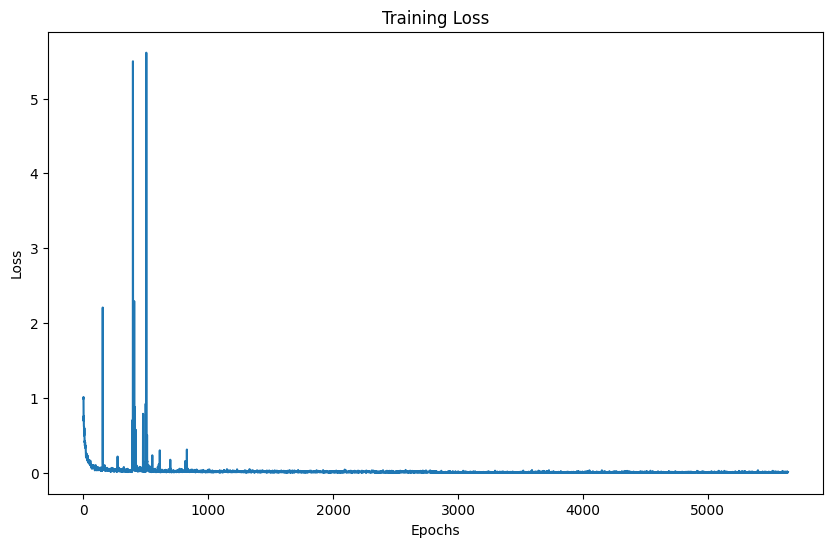

Last Loss 0.009280168451368809


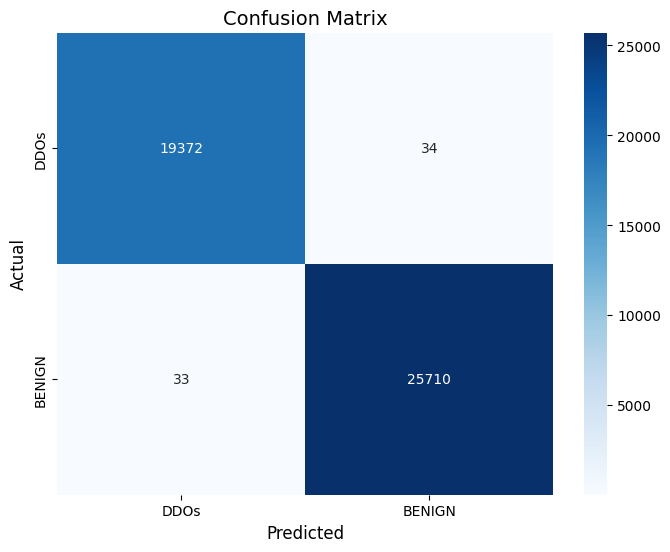

TP:  25710
FP:  33
TN:  19372
FN:  34
Accuracy:  0.9985160247181555
Precision:  0.9987180981237618
Recall:  0.9986793039154754
F-1 score: 0.9986987006428807


In [20]:

network_model_1 = NetworkModel(58, out_features, d_model, d_attention)
training_loop(epochs,network_model_1,bwd_train_dataLoader)
(all_prediction, all_label) = evaluation_loop(network_model_1,bwd_test_dataLoader)
networkModel1_accuracies, networkModel1_precision, networkModel1_recall, networkModel1_f1 = graph_results(all_prediction, all_label)

Time Completed:   161.65876126289368


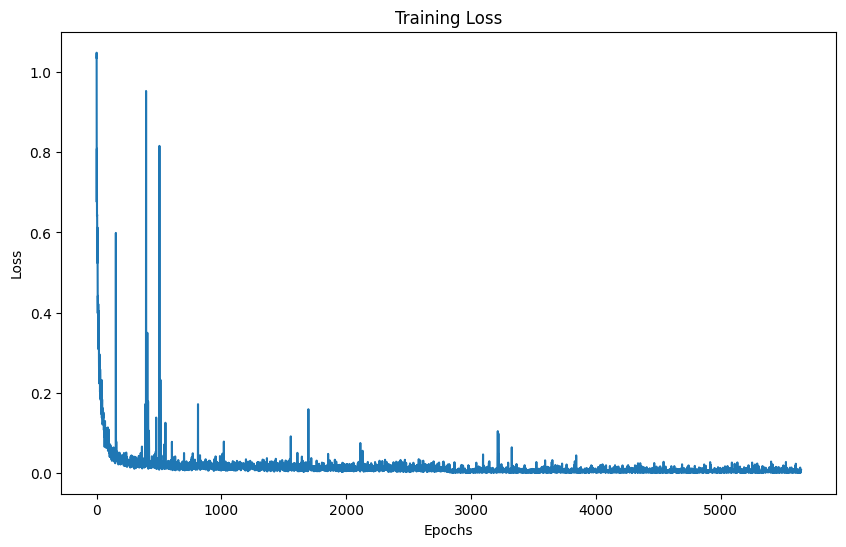

Last Loss 0.007149646990001202


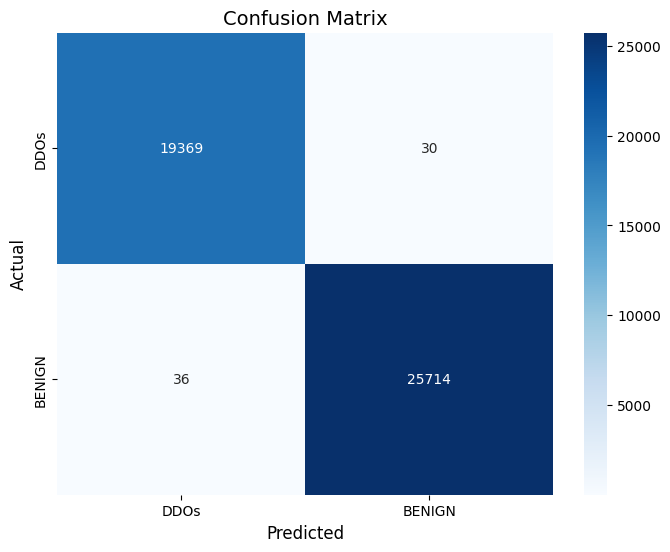

TP:  25714
FP:  36
TN:  19369
FN:  30
Accuracy:  0.998538173602959
Precision:  0.9986019417475728
Recall:  0.9988346799254195
F-1 score: 0.9987182972773527


In [21]:
network_model_2 = NetworkModel(62, out_features, d_model, d_attention)
training_loop(epochs,network_model_2,fwd_train_dataLoader)
(all_prediction, all_label) = evaluation_loop(network_model_2,fwd_test_dataLoader)
networkModel2_accuracies, networkModel2_precision, networkModel2_recall, networkModel2_f1 = graph_results(all_prediction, all_label)

Time Completed:   164.4931378364563


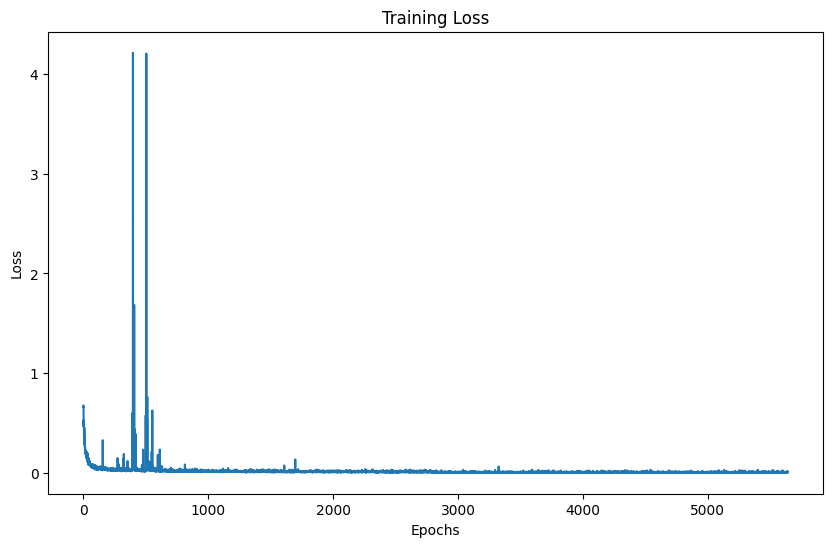

Last Loss 0.00994537677615881


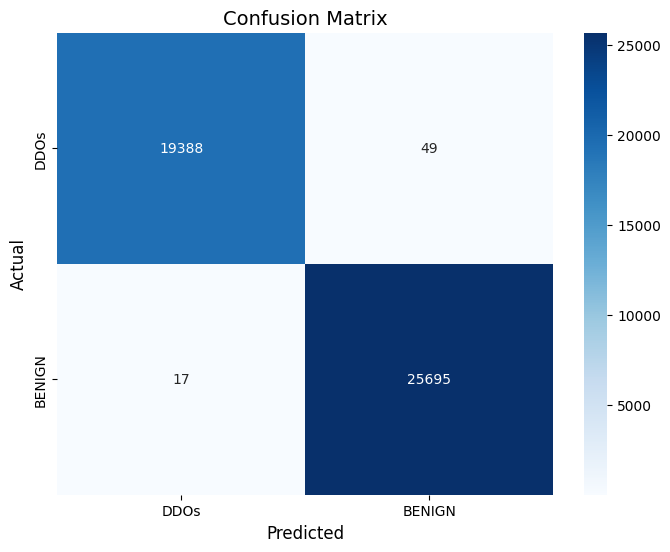

TP:  25695
FP:  17
TN:  19388
FN:  49
Accuracy:  0.998538173602959
Precision:  0.9993388301182328
Recall:  0.9980966438781852
F-1 score: 0.9987173507462687


In [22]:
network_model_3 = NetworkModel(71, out_features, d_model, d_attention)
training_loop(epochs,network_model_3,flow_train_dataLoader)
(all_prediction, all_label) = evaluation_loop(network_model_3,flow_test_dataLoader)
networkModel3_accuracies, networkModel3_precision, networkModel3_recall, networkModel3_f1 = graph_results(all_prediction, all_label)

Time Completed:   161.5660490989685


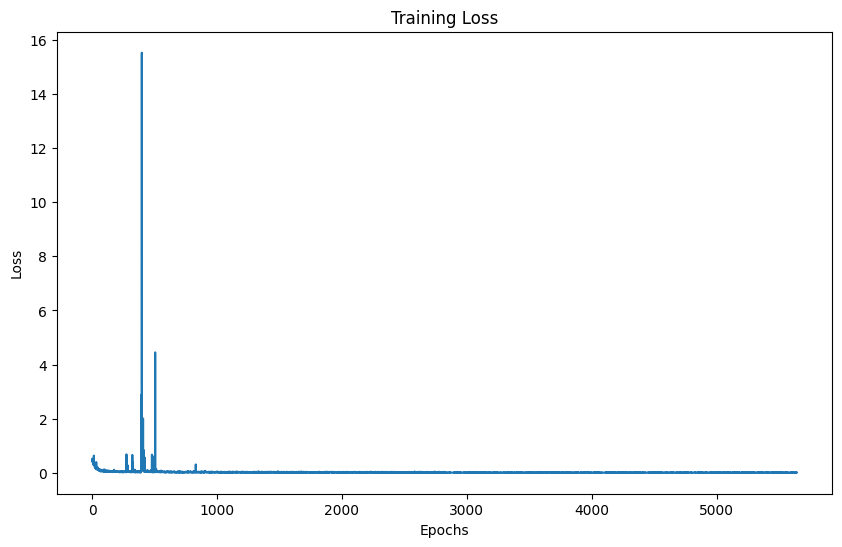

Last Loss 0.008137889206409454


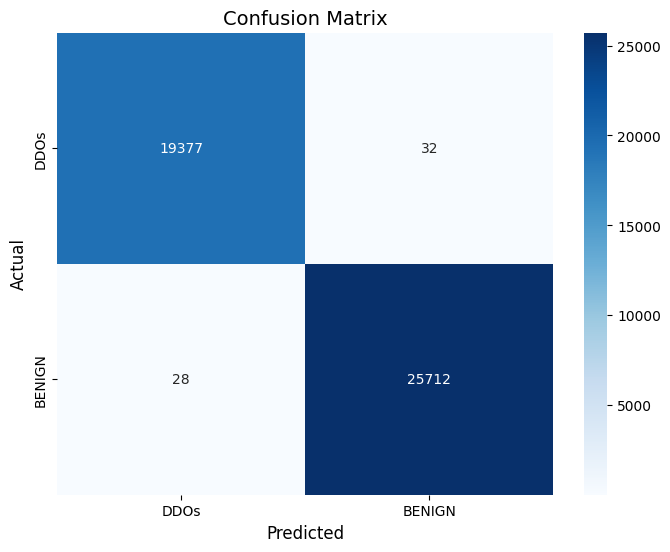

TP:  25712
FP:  28
TN:  19377
FN:  32
Accuracy:  0.998671066911781
Precision:  0.998912198912199
Recall:  0.9987569919204475
F-1 score: 0.998834589386994


In [23]:
network_model_4 = NetworkModel(69, out_features, d_model, d_attention)
training_loop(epochs,network_model_4,flag_train_dataLoader)
(all_prediction, all_label) = evaluation_loop(network_model_4,flag_test_dataLoader)
networkModel4_accuracies, networkModel4_precision, networkModel4_recall, networkModel4_f1 = graph_results(all_prediction, all_label)

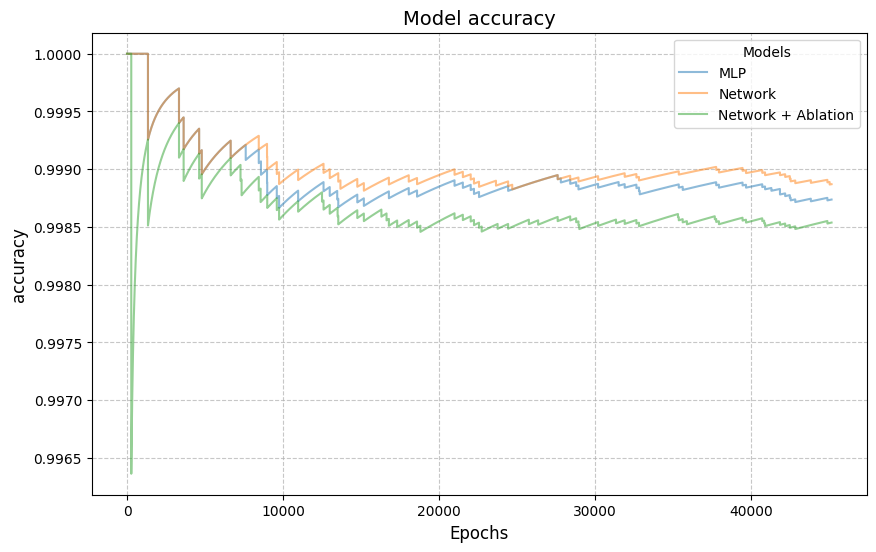

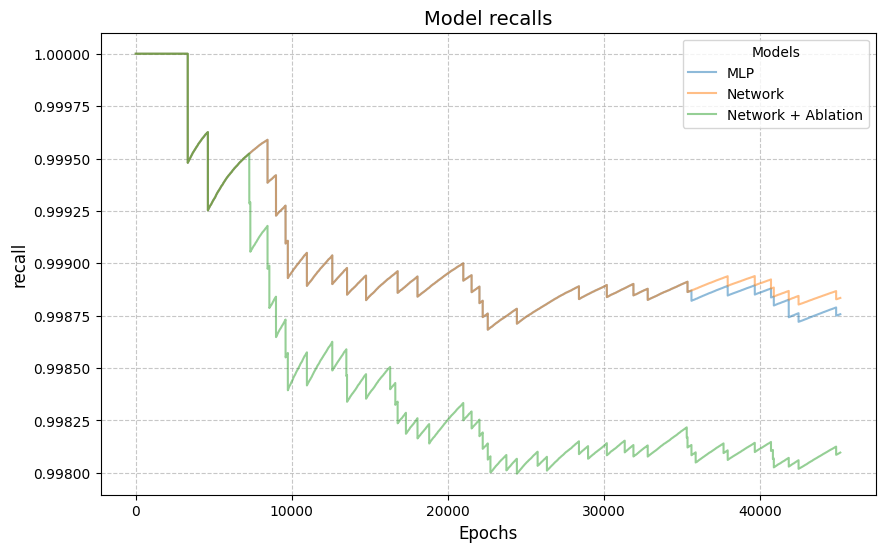

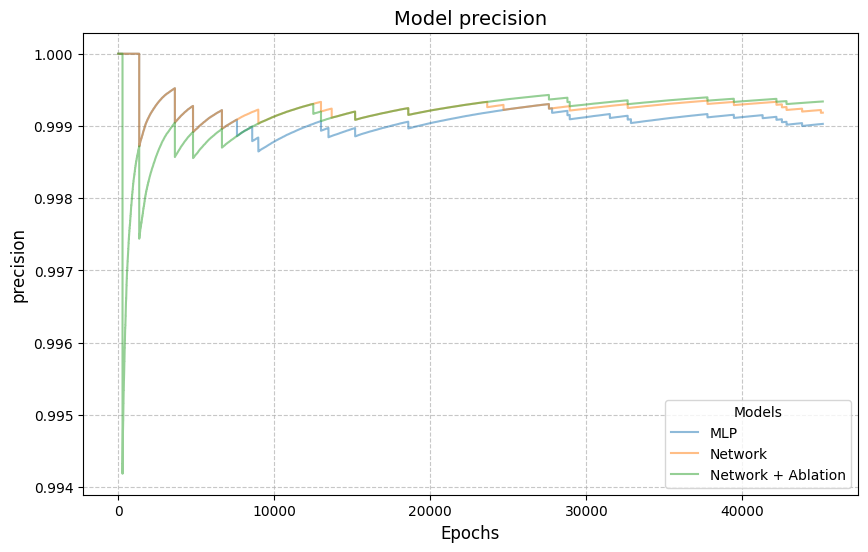

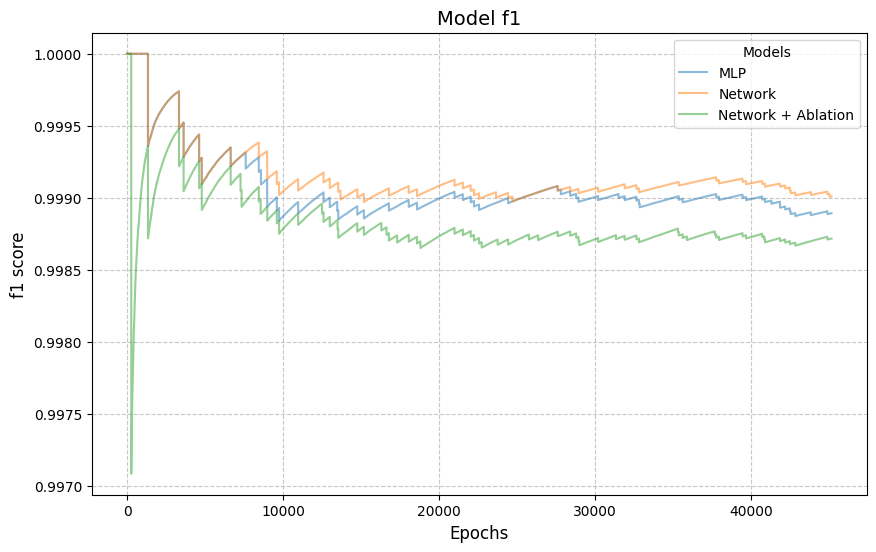

In [24]:

def model_compare_graphs(model1_metric, model2_metric, model3_metric, titleString, label_string, model_names=None, inFilter=0):
    # Default model names if none are provided

    if model_names is None:
        model_names = ['Model 1', 'Model 2', 'Model 3']

    plt.figure(figsize=(10, 6))

    # Plot each model's metrics
    plt.plot(model1_metric[inFilter:], label=model_names[0], linestyle='-',alpha=0.5)
    plt.plot(model2_metric[inFilter:], label=model_names[1], linestyle='-',alpha=0.5)
    plt.plot(model3_metric[inFilter:], label=model_names[2], linestyle='-',alpha=0.5)

    # Labels and title
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel(label_string, fontsize=12)
    plt.title(titleString, fontsize=14)

    # Add legend for clarity
    plt.legend(title="Models", fontsize=10)

    # Show grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

model_compare_graphs(mlp_accuracies,networkModel_accuracies,networkModel3_accuracies, "Model accuracy","accuracy",['MLP',"Network","Network + Ablation"],inFilter=0)
model_compare_graphs(mlp_recall,networkModel_recall,networkModel3_recall, "Model recalls","recall",['MLP',"Network","Network + Ablation"],inFilter=0)
model_compare_graphs(mlp_precision,networkModel_precision,networkModel3_precision, "Model precision","precision",['MLP',"Network","Network + Ablation"],inFilter=0)
model_compare_graphs(mlp_f1,networkModel_f1,networkModel3_f1, "Model f1","f1 score",['MLP',"Network","Network + Ablation"],inFilter=0)

In [25]:
import numpy as np
import scipy.stats as stats

# Function to conduct a T-Test
def conduct_ttest(base_model: list, sample_model: list):
    base_model = np.array(base_model)
    sample_model = np.array(sample_model)

    sample_mean = np.mean(sample_model)
    base_mean = np.mean(base_model)
    sample_std = np.std(sample_model, ddof=1)  # Use ddof=1 for sample standard deviation
    sample_size = len(sample_model)


    t_statistic = (sample_mean - base_mean) / (sample_std / np.sqrt(sample_size))
    df = sample_size - 1
    alpha = 0.05
    critical_t = stats.t.ppf(1 - alpha, df)
    p_value = 1 - stats.t.cdf(t_statistic, df)


    # Print the results
    print("T-Statistic:", t_statistic)
    print("Critical t-value:", critical_t)
    print("P-Value:", p_value)

    # Decision based on T-value
    print('Decision using T-value:')
    if abs(t_statistic) > critical_t:
        print("""There is a significant difference between the base model and the sample model.
The models are likely to perform differently.""")
    else:
        print("""There is no significant difference between the base model and the sample model.
The models perform similarly.""")

    # Decision based on P-value
    print('Decision using P-value:')
    if p_value < alpha:
        print("""There is a significant difference between the base model and the sample model.
The models are likely to perform differently.""")
    else:
        print("""There is no significant difference between the base model and the sample model.
The models perform similarly.""")

print("----Accuracies----")
t_score = conduct_ttest(mlp_accuracies, networkModel3_accuracies)
t_score = conduct_ttest(mlp_accuracies, networkModel_accuracies)
print("----Precision----")
t_score = conduct_ttest(mlp_precision, networkModel3_precision)
t_score = conduct_ttest(mlp_precision, networkModel_precision)
print("----Recall----")
t_score = conduct_ttest(mlp_recall, networkModel3_recall)
t_score = conduct_ttest(mlp_recall, networkModel_recall)
print("----F1 Score----")
t_score = conduct_ttest(mlp_f1, networkModel3_f1)
t_score = conduct_ttest(mlp_f1, networkModel_f1)


----Accuracies----
T-Statistic: -261.5108594873713
Critical t-value: 1.6448873781830808
P-Value: 1.0
Decision using T-value:
There is a significant difference between the base model and the sample model.
The models are likely to perform differently.
Decision using P-value:
There is no significant difference between the base model and the sample model.
The models perform similarly.
T-Statistic: 85.09901401058036
Critical t-value: 1.6448873781830808
P-Value: 0.0
Decision using T-value:
There is a significant difference between the base model and the sample model.
The models are likely to perform differently.
Decision using P-value:
There is a significant difference between the base model and the sample model.
The models are likely to perform differently.
----Precision----
T-Statistic: 25.290780951572394
Critical t-value: 1.6448873781830808
P-Value: 0.0
Decision using T-value:
There is a significant difference between the base model and the sample model.
The models are likely to perform d